In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_auc_score, roc_curve)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

ImportError: cannot import name 'arrow_table_to_pandas' from 'pandas.io._util' (c:\Users\Usuario\anaconda3\envs\MITxPRO\Lib\site-packages\pandas\io\_util.py)

In [ ]:
print(f"\n🔧 PREPARACIÓN DE DATOS:")

# Generamos dummy variables
data = pd.get_dummies(data, columns=['DEPARTAMENTO'], drop_first=False)
data['SEXO'] = data['SEXO'].map({'F': 0, 'M': 1})
data['SEXO'] = data['SEXO'].fillna(0)
data['TIPO_VENDEDOR'] = data['TIPO_VENDEDOR'].map({'Asesora': 0, 'Líder': 1})

# Separar características y variable objetivo
X = data.drop('TARGET_CHURN', axis=1)
y = data['TARGET_CHURN']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"   • Tamaño conjunto entrenamiento: {X_train.shape}")
print(f"   • Tamaño conjunto prueba: {X_test.shape}")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   • Características escaladas ✅")



🔧 PREPARACIÓN DE DATOS:
   • Tamaño conjunto entrenamiento: (13648, 46)
   • Tamaño conjunto prueba: (3412, 46)
   • Características escaladas ✅


In [ ]:
# =================================

print(f"\n⚖️  BALANCEADO DE DATOS:")

# Verificar si es necesario balancear
class_counts = y_train.value_counts()
balance_ratio = min(class_counts) / max(class_counts)
print(f"   • Ratio de balance: {balance_ratio:.3f}")

if balance_ratio < 0.8:  # Si el desbalance es significativo
    print(f"   • Aplicando SMOTE + Tomek Links...")

    # Aplicar SMOTE + Tomek Links
    smote_tomek = SMOTETomek(random_state=42)
    X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)

    print(f"   • Datos balanceados:")
    print(f"     - Antes: {y_train.value_counts().to_dict()}")
    print(f"     - Después: {pd.Series(y_train_balanced).value_counts().to_dict()}")

    # Visualizar el balanceado
    plot_class_balance(pd.Series(y_train_balanced), "Distribución Después del Balanceado")

    # Usar datos balanceados
    X_train_final = X_train_balanced
    y_train_final = y_train_balanced
else:
    print(f"   • No es necesario balancear los datos")
    X_train_final = X_train_scaled
    y_train_final = y_train




⚖️  BALANCEADO DE DATOS:
   • Ratio de balance: 0.812
   • No es necesario balancear los datos


#ENTRENAMIENTO

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

print(f"\n⚖️  OPTIMIZACIÓN DE HIPERPARÁMETROS:")

# Hiperparámetros por modelo
params = {
    "SVM": {
        "kernel": ["rbf"],
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto", 0.1, 0.01]
    },
    "RF": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5, 10]
    },
    "XGB": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }
}

# Modelos base
modelos_gridsearch = {
    "SVM": SVC(random_state=42, probability=True),
    "RF": RandomForestClassifier(random_state=42),
    "XGB": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Para guardar resultados
models_results = {}

# GridSearchCV
for name, model in modelos_gridsearch.items():
    print(f"\n🔍 Modelo: {name}")
    print(f"   Parámetros: {params[name]}")
    gs = GridSearchCV(model, params[name], cv=5, n_jobs=-1, scoring='f1')
    gs.fit(X_train_final, y_train_final)

    best_model = gs.best_estimator_
    best_params = gs.best_params_
    preds = best_model.predict(X_test_scaled)

    models_results[name] = {
        "model": best_model,
        "params": best_params,
        "predictions": preds
    }

    print(f"✅ Mejor combinación: {best_params}")
    print(f"📈 Mejor F1-Score (cv): {gs.best_score_:.4f}")



⚖️  OPTIMIZACIÓN DE HIPERPARÁMETROS:

🔍 Modelo: SVM
   Parámetros: {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 0.01]}
✅ Mejor combinación: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
📈 Mejor F1-Score (cv): 0.7491

🔍 Modelo: RF
   Parámetros: {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5, 10]}
✅ Mejor combinación: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
📈 Mejor F1-Score (cv): 0.7393

🔍 Modelo: XGB
   Parámetros: {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}
✅ Mejor combinación: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
📈 Mejor F1-Score (cv): 0.7480


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import pandas as pd
import matplotlib.pyplot as plt

# =================================
# 📊 EVALUACIÓN DE MODELOS
# =================================

print(f"\n📊 EVALUACIÓN DE MODELOS:")

evaluation_results = []

def evaluate_model(model, X_test, y_test, preds, name):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1-Score": f1_score(y_test, preds),
        "ROC-AUC": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, "predict_proba") else roc_auc_score(y_test, model.decision_function(X_test))
    }

for model_name, results in models_results.items():
    model = results['model']
    preds = results['predictions']

    # Guardar métricas generales
    metrics = evaluate_model(model, X_test_scaled, y_test, preds, model_name)
    evaluation_results.append(metrics)

    # === Imprimir métricas generales ===
    print(f"\n🔸 {model_name}:")
    print(f"   • Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"   • Precision: {metrics['Precision']:.4f}")
    print(f"   • Recall:    {metrics['Recall']:.4f}")
    print(f"   • F1-Score:  {metrics['F1-Score']:.4f}")
    print(f"   • ROC-AUC:   {metrics['ROC-AUC']:.4f}")

    # === Reporte detallado por clase ===
    print(f"\n📄 Classification Report ({model_name}):")
    print(classification_report(y_test, preds, digits=4))


# === Tabla resumen ===
results_df = pd.DataFrame(evaluation_results).set_index('Model').round(4)

print(f"\n📋 TABLA COMPARATIVA DE RESULTADOS:")
print("=" * 60)
print(results_df)

# === Mejores modelos por métrica ===
print(f"\n🏆 MEJORES MODELOS POR MÉTRICA:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"   • {metric:<10}: {best_model} ({best_score:.4f})")



📊 EVALUACIÓN DE MODELOS:

🔸 SVM:
   • Accuracy:  0.6761
   • Precision: 0.6515
   • Recall:    0.8797
   • F1-Score:  0.7486
   • ROC-AUC:   0.7472

📄 Classification Report (SVM):
              precision    recall  f1-score   support

           0     0.7463    0.4293    0.5451      1542
           1     0.6515    0.8797    0.7486      1870

    accuracy                         0.6761      3412
   macro avg     0.6989    0.6545    0.6468      3412
weighted avg     0.6944    0.6761    0.6566      3412


🔸 RF:
   • Accuracy:  0.6782
   • Precision: 0.6731
   • Recall:    0.8027
   • F1-Score:  0.7322
   • ROC-AUC:   0.7504

📄 Classification Report (RF):
              precision    recall  f1-score   support

           0     0.6878    0.5272    0.5969      1542
           1     0.6731    0.8027    0.7322      1870

    accuracy                         0.6782      3412
   macro avg     0.6805    0.6650    0.6646      3412
weighted avg     0.6797    0.6782    0.6711      3412


🔸 XGB:
   •


📈 GENERANDO VISUALIZACIONES:


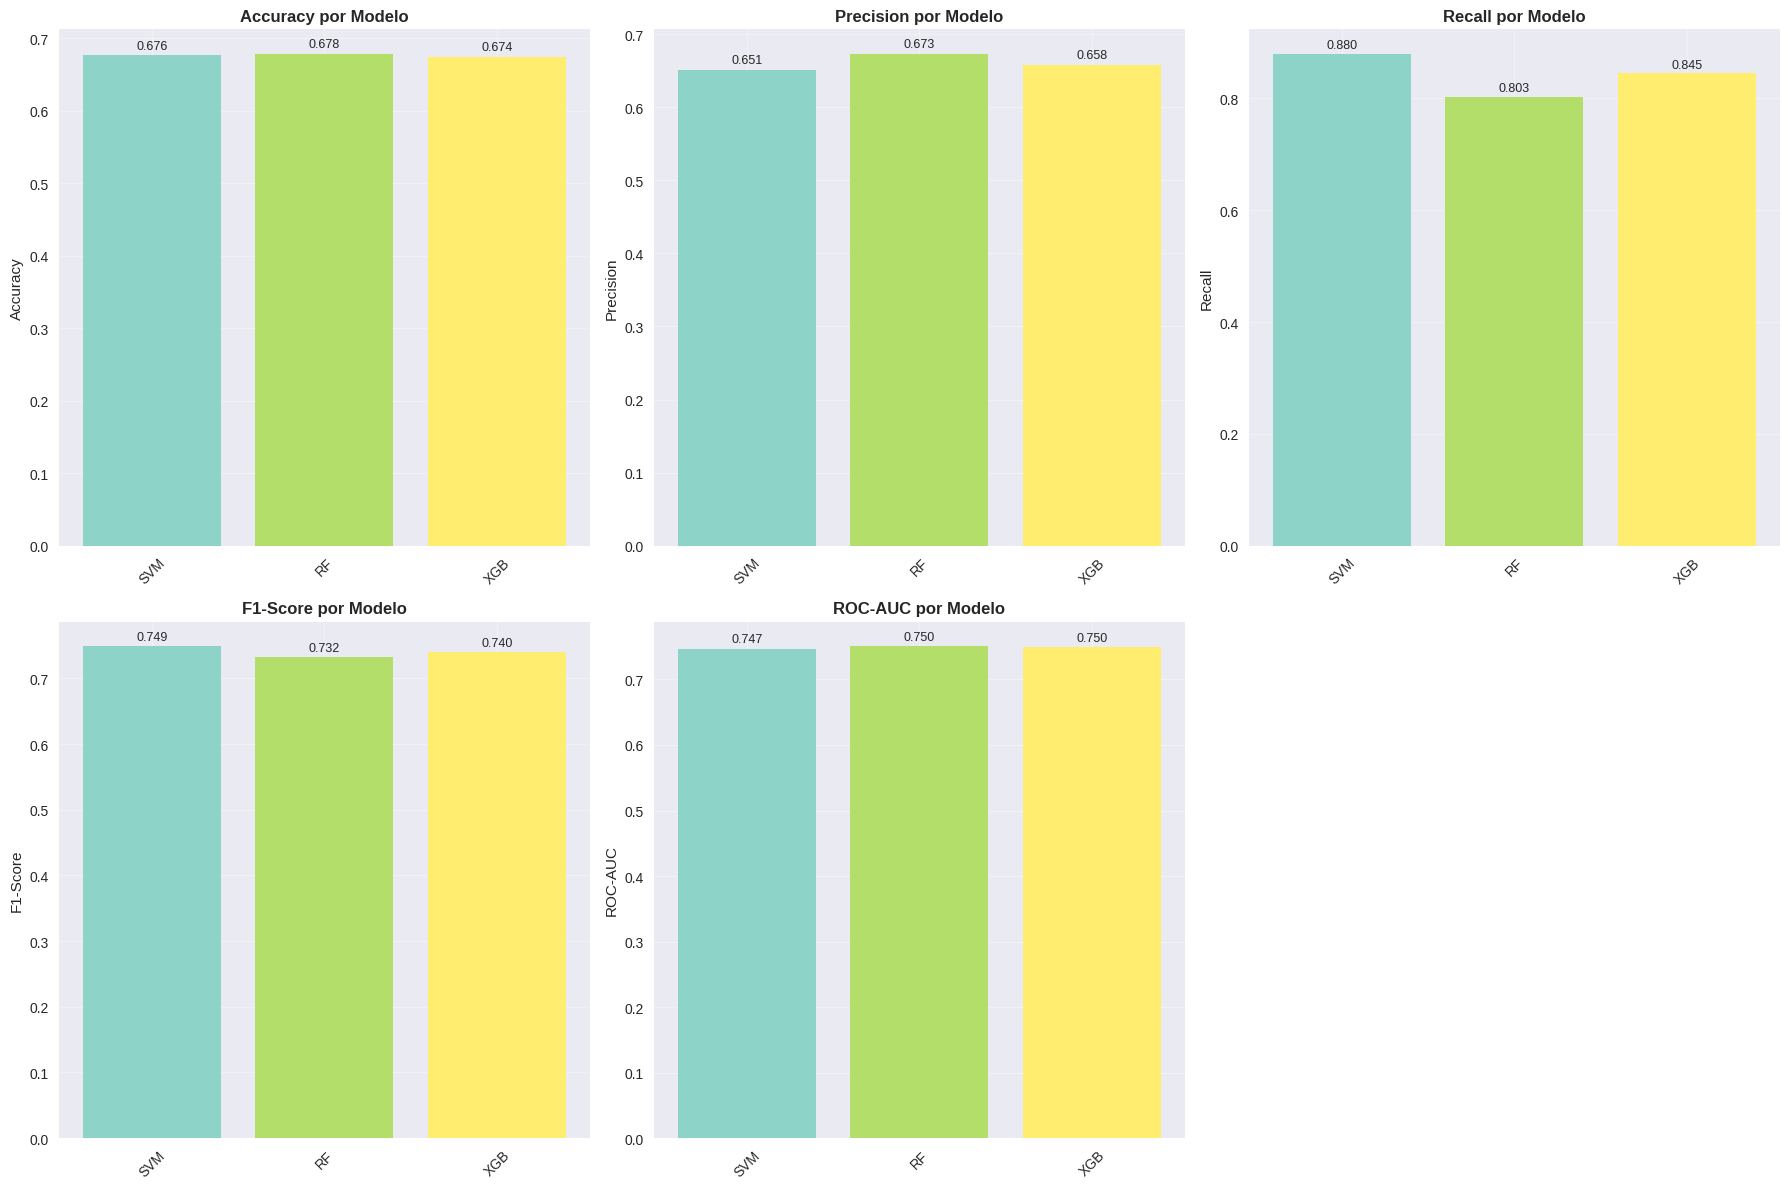

AttributeError: 'numpy.ndarray' object has no attribute 'spines'

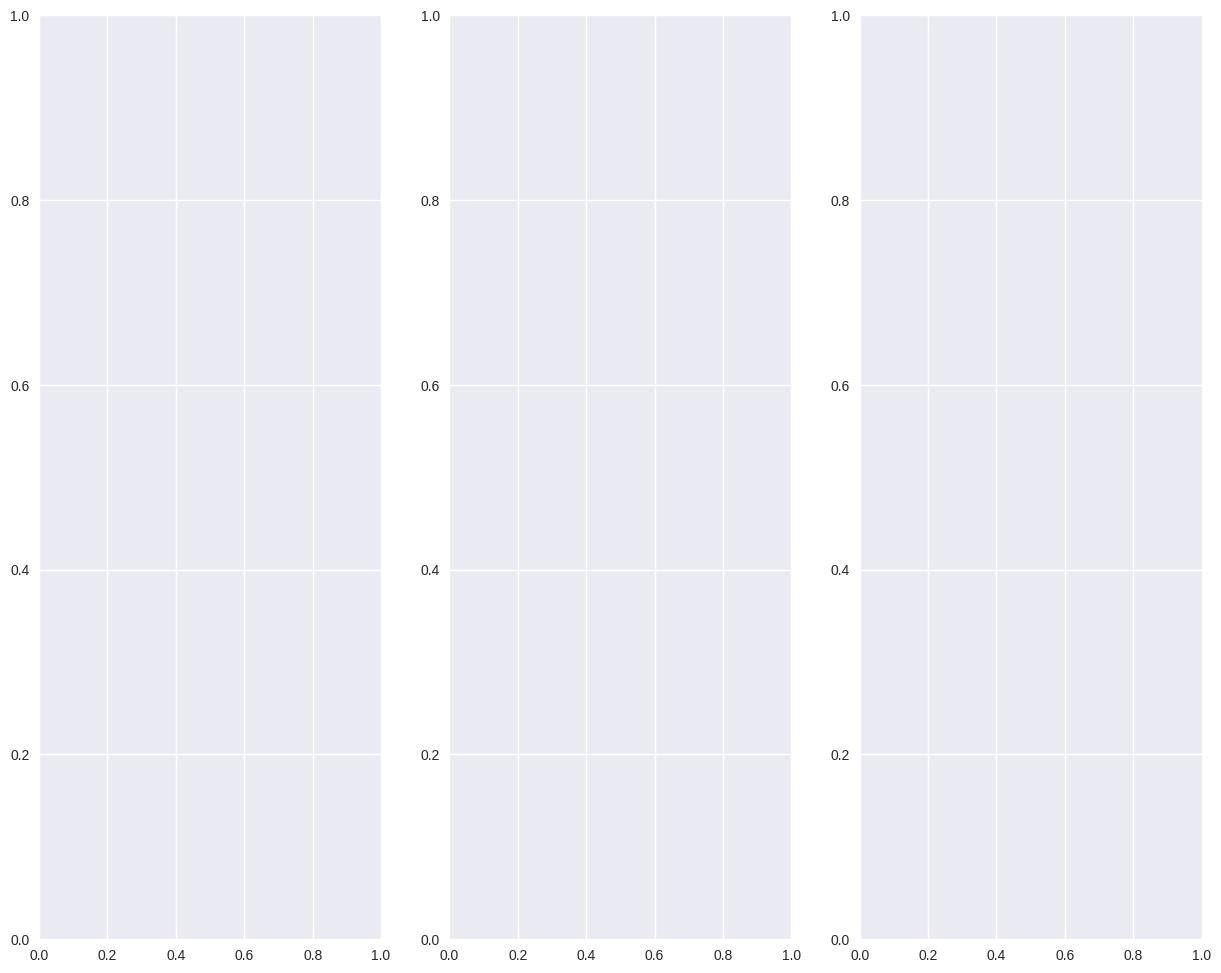

In [ ]:
# 12. VISUALIZACIÓN DE RESULTADOS
# ===============================

print(f"\n📈 GENERANDO VISUALIZACIONES:")

# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))

for i, metric in enumerate(metrics):
    if i < len(axes):
        bars = axes[i].bar(results_df.index, results_df[metric], color=colors)
        axes[i].set_title(f'{metric} por Modelo', fontweight='bold')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)

        # Agregar valores en las barras
        for bar, value in zip(bars, results_df[metric]):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# Ocultar el último subplot si es necesario
if len(metrics) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Matrices de confusión
plot_confusion_matrices(models_results, y_test)

# Curvas ROC
plot_roc_curves(models_results, y_test)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Paso 1: Reconstruir el DataFrame con nombres reales
X_train_final_df = pd.DataFrame(X_train_final, columns=X_train.columns)

# Paso 2: Asignar nombres al booster
booster = xgboost_best.get_booster()
booster.feature_names = X_train_final_df.columns.tolist()

# Paso 3: Graficar la importancia de variables
plt.figure(figsize=(10, 8))
plot_importance(
    booster,
    max_num_features=25,
    importance_type="gain",  # o "weight", "cover"
    show_values=False
)
plt.title("Feature importance – XGBoost (gain)")
plt.tight_layout()
plt.show()


In [ ]:
scores = cross_val_score(
    xgboost_best,
    X_train_final,
    y_train_final,
    cv=10,
    scoring='f1',
    n_jobs=-1
)

print(f"F1 promedio  (10‑fold CV): {scores.mean():.3f} ± {scores.std():.3f}")


In [ ]:
import joblib

joblib.dump(xgboost_best, 'modelo_churn_xgboost.pkl')
print("✅ Modelo guardado correctamente.")


In [ ]:
from google.colab import files
#files.download('modelo_churn_xgboost.pkl')

In [ ]:
import shap

# 1. Reconstruir X_test con nombres
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 2. Recalcular SHAP con el DataFrame con nombres
explainer = shap.Explainer(xgboost_best)
shap_values = explainer(X_test_scaled_df)

# 3. Gráfico con nombres correctos
shap.summary_plot(shap_values, X_test_scaled_df)


In [ ]:
import joblib

#modelo = joblib.load('modelo_churn_xgboost.pkl')

In [ ]:
#import pandas as pd
validation_data = pd.read_excel('testdata.xlsx')

In [ ]:
validation_data = validation_data[validation_data['MONTO PEDIDOS'] != 0].copy()
validation_data['ANTIGUEDAD DIAS'] = validation_data['ANTIGUEDAD DIAS'].clip(lower=0)
validation_data.dropna(inplace=True)
validation_data = pd.get_dummies(validation_data, columns=['TIPO VENDEDOR', 'DEPARTAMENTO'], drop_first=False)

X = validation_data.drop('CHURN', axis=1)
y = validation_data['CHURN']


scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"   • Características escaladas ✅")


In [ ]:
y_pred = xgboost_best.predict(X)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("📊 Clasification Report:")
print(classification_report(y, y_pred))

print("🧾 Matriz de confusión:")
print(confusion_matrix(y, y_pred))
